In [1]:
import pandas as pd
from glob import glob
from barplots import barplots
from tqdm.auto import tqdm

In [2]:
results = pd.concat([
    pd.read_csv(path, index_col=0)
    for path in glob("reports/*.csv")
])

results["window"] = [
    row.model.split("_")[-1]
    for _, row in results.iterrows()
]

results.model = [
    f"{row.model}_weight_{row.trained_on.split('_')[-1]}"
    if "weight" in row.trained_on else row.model
    for _, row in results.iterrows()
]

results["weight"] = [
    "Weight {}".format(row.trained_on.split("_")[-1])
    if "weight" in row.trained_on else "Unweighted"
    for _, row in results.iterrows()
]

results.trained_on = [
    row.trained_on.split("_with_weight")[0]
    if "weight" in row.trained_on else row.trained_on
    for _, row in results.iterrows()
]

In [3]:
def reverse(my_list):
    return list(reversed(my_list))

In [4]:
facecolor = "#ffffb3"

cae_colors = {
    '200':"#6baed6",
    '500':"#3182bd",
    '1000':"#08519c",      
}

best_models_colors = {
    'Best cae':"#08519c",      
    "Best cnn": "#e6550d",
    "KNN 10k": "#4C2D5D",
    "KNN 1024": "#A663CC",
    "KNN 5": "#B298DC"
}

cnn_colors = {
    'cnn_200':"#fdae6b",
    'cnn_500':"#fd8d3c",
    'cnn_1000':"#e6550d",   
}

kwargs = dict(
    show_standard_deviation=False,
    subplots=True,
    orientation="horizontal",
    plots_per_row=5,
    major_rotation=90,
    use_multiprocessing=False,
    verbose=False,
    unique_minor_labels=True,
    show_legend=False,
    sort_subplots=reverse,
)

# Visualization of tasks (Unweighted CAE models)
Considering all metrics.

In [5]:
def sort_dataframe1(df:pd.DataFrame):
    target = {
        'all_nucleotides':4,
        'adenine':3,
        'cytosine':2,
        'thymine':1,
        'guanine':0
    }
    
    model = {
        key:i
        for i, key in enumerate([
            'cae_1000',
            'cae_500',
            'cae_200',
            'Best cae',
            'Best cnn',
            "KNN 10k",
            "KNN 1024",
            "KNN 5"
        ])
    }
    
    df['sort_val'] = [
        (target[row.target]*10 if "target" in row else 0) + model[row.model]
        for (_, row) in df.reset_index().iterrows()
    ]
    return df.sort_values('sort_val').drop(columns='sort_val')

# Visualization of tasks (Weighted CAE models)
Considering only categorical metrics.

In [6]:
def sort_dataframe2(df:pd.DataFrame):    
    window = {
        key:i
        for i, key in enumerate([
            'cae 1000',
            'cae 500',
            'cae 200'
        ])
    }
    
    weight = {
        key:i*10
        for i, key in enumerate([
            'Weight 10',
            'Weight 2',
            'Unweighted',
        ])
    }
    
    df['sort_val'] = [
        window[row.window] + weight[row.weight]
        for (_, row) in df.reset_index().iterrows()
    ]
    return df.sort_values('sort_val').drop(columns='sort_val')

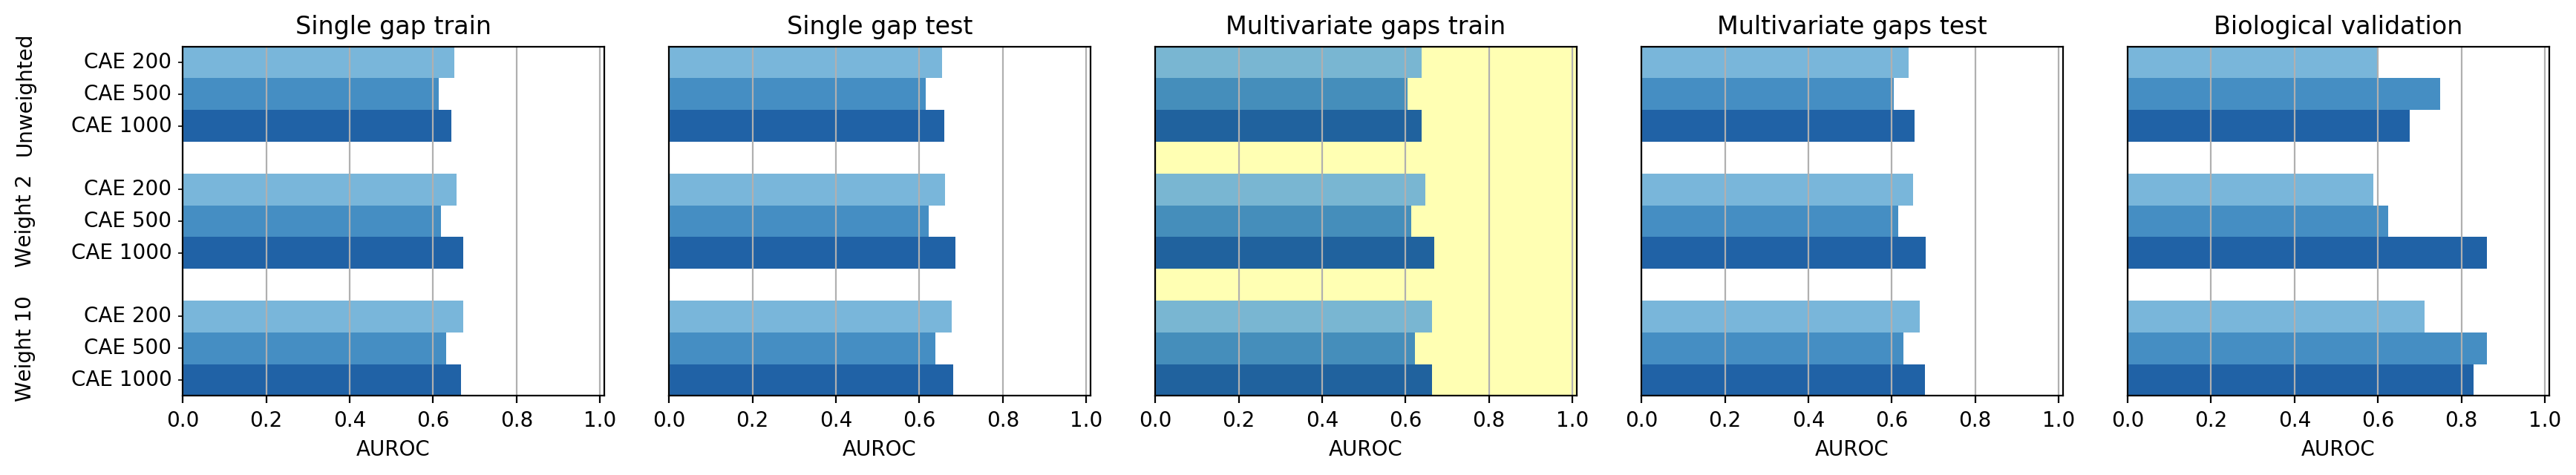

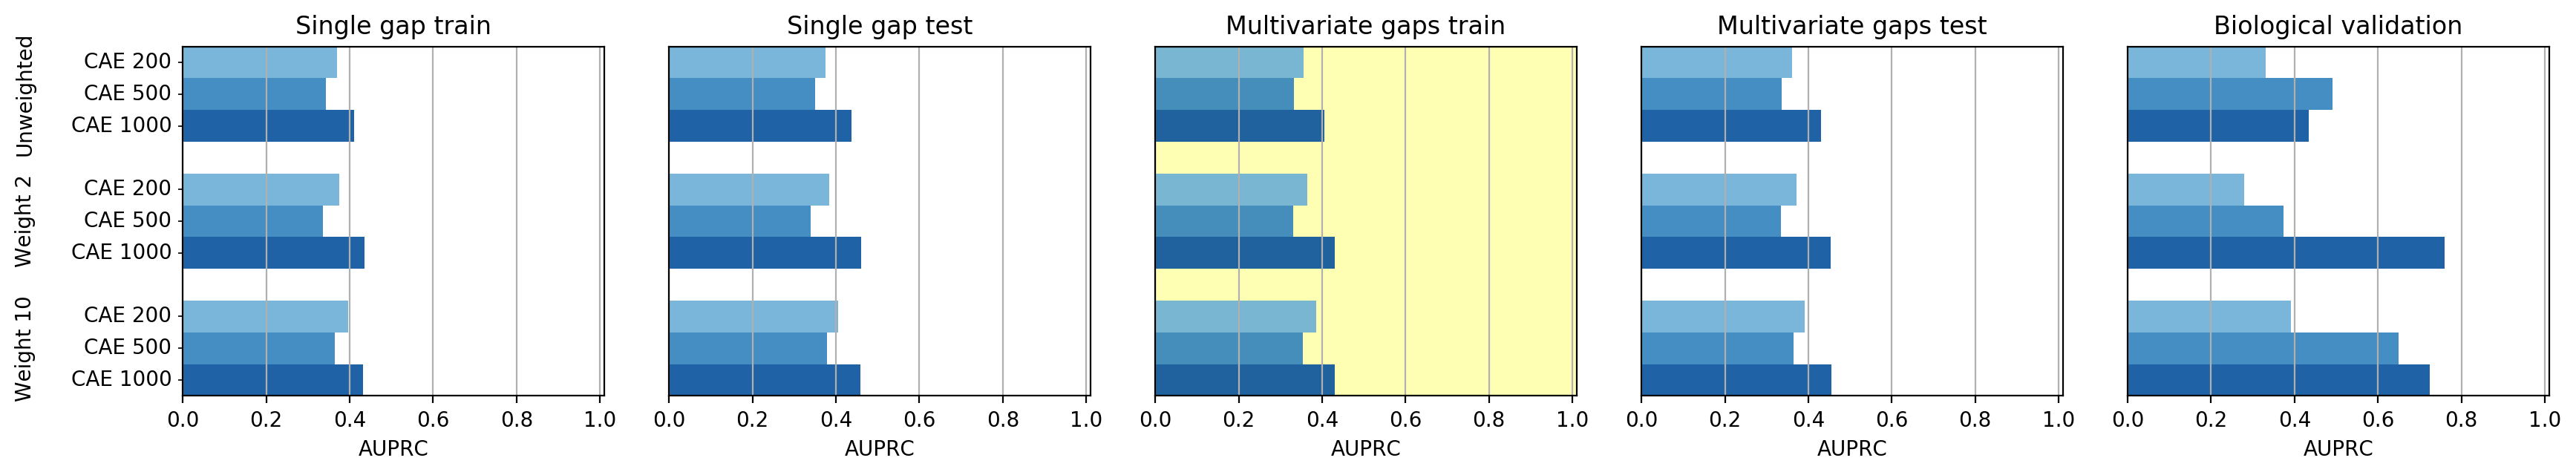

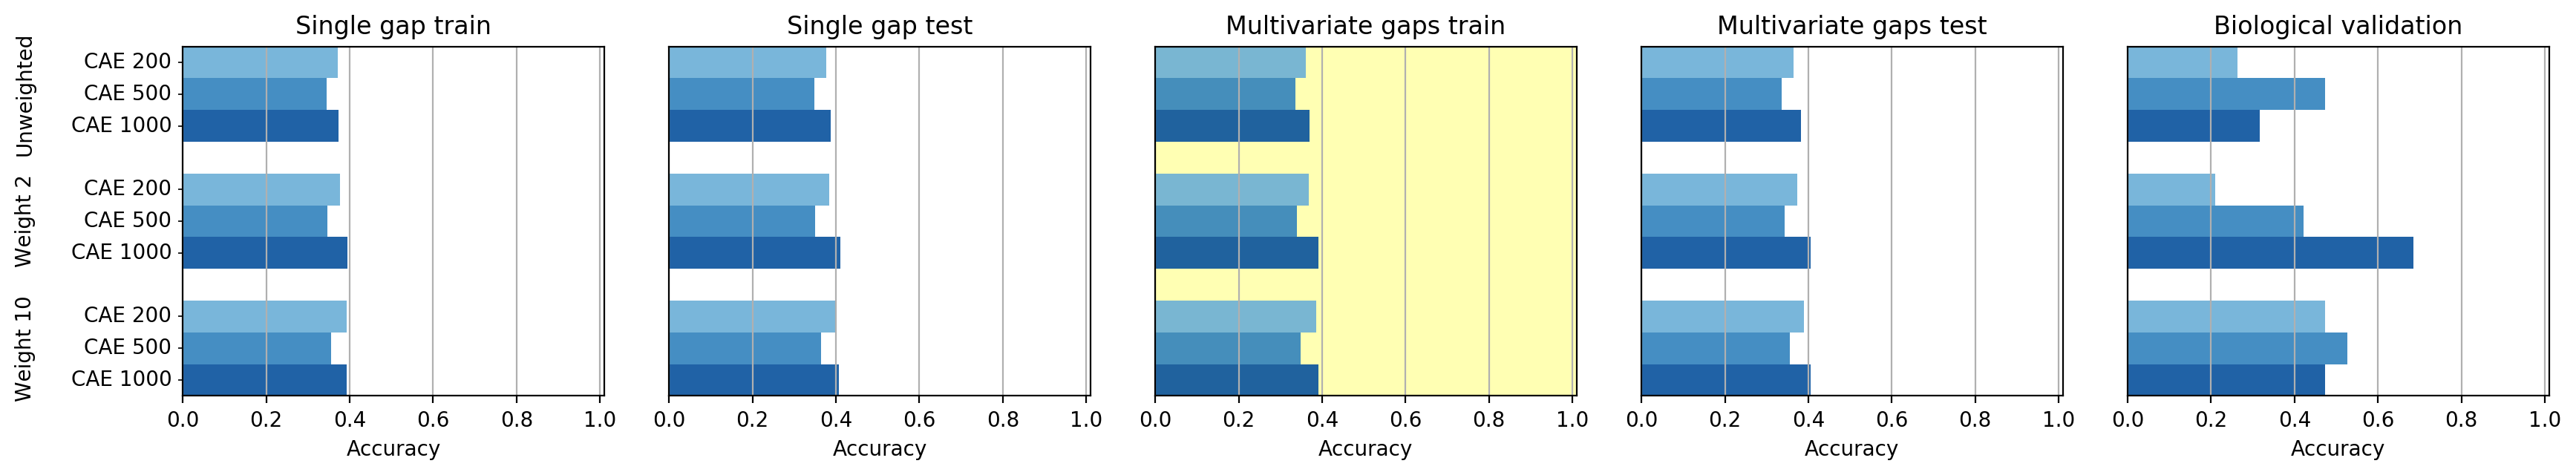

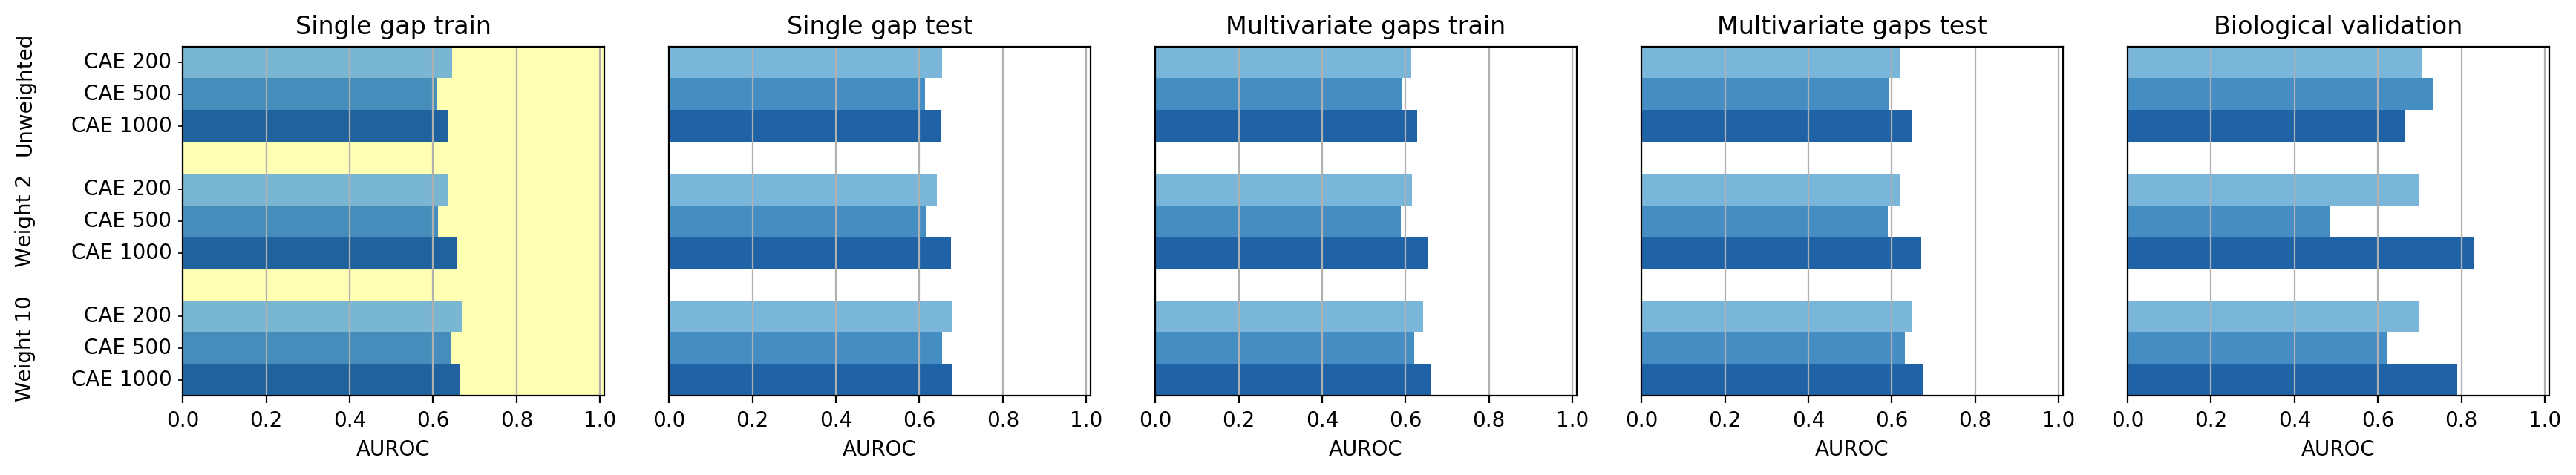

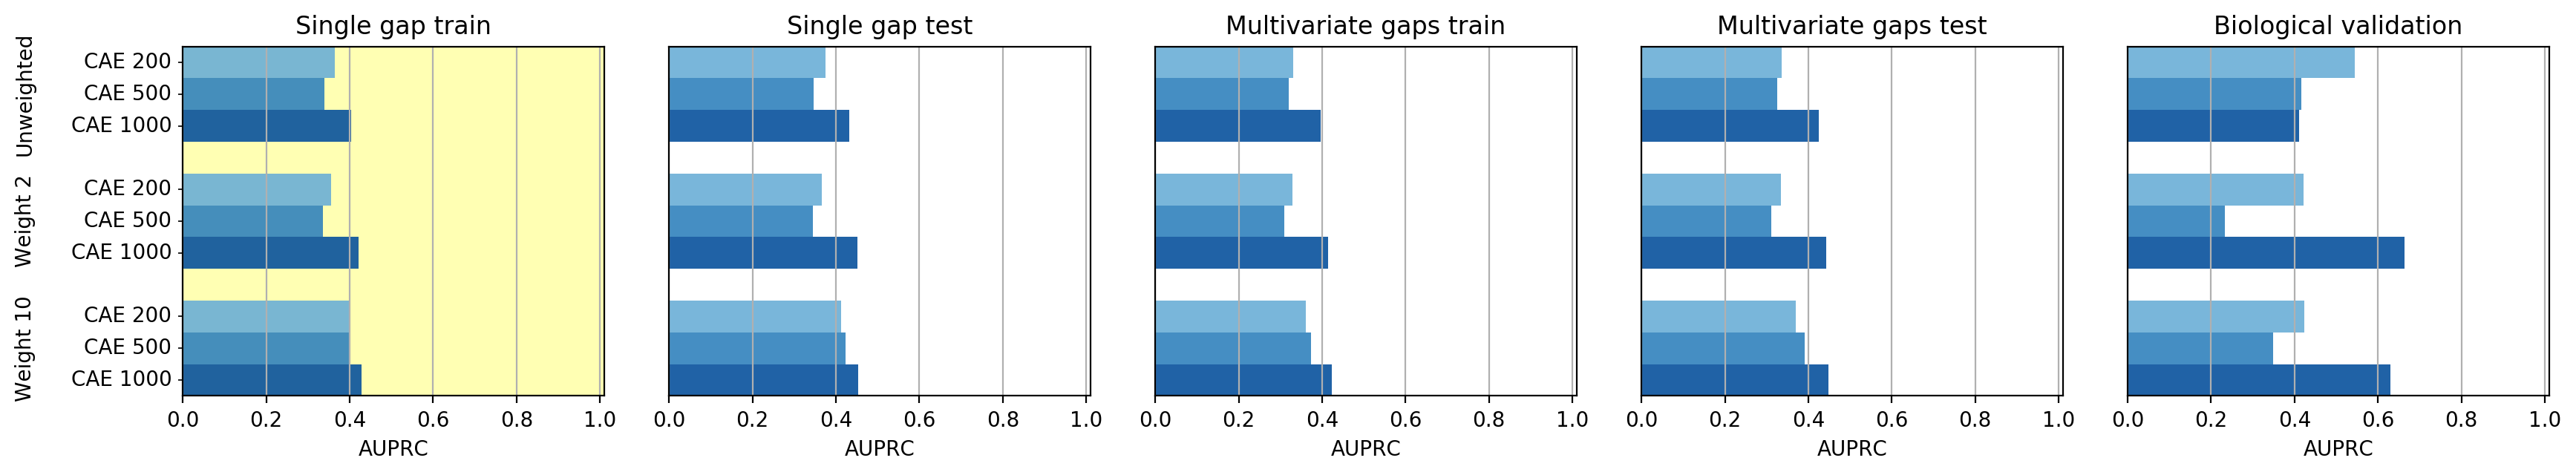

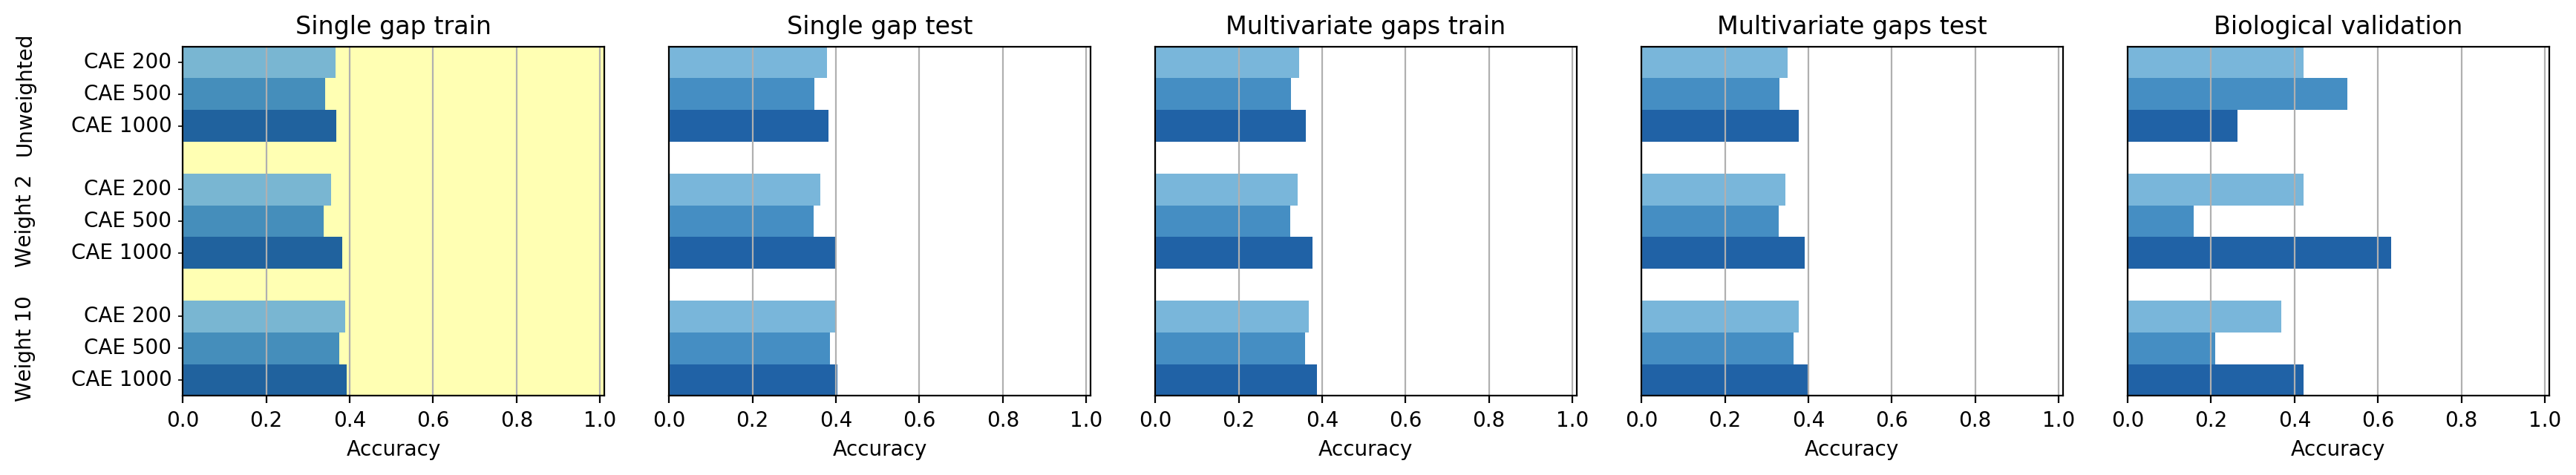

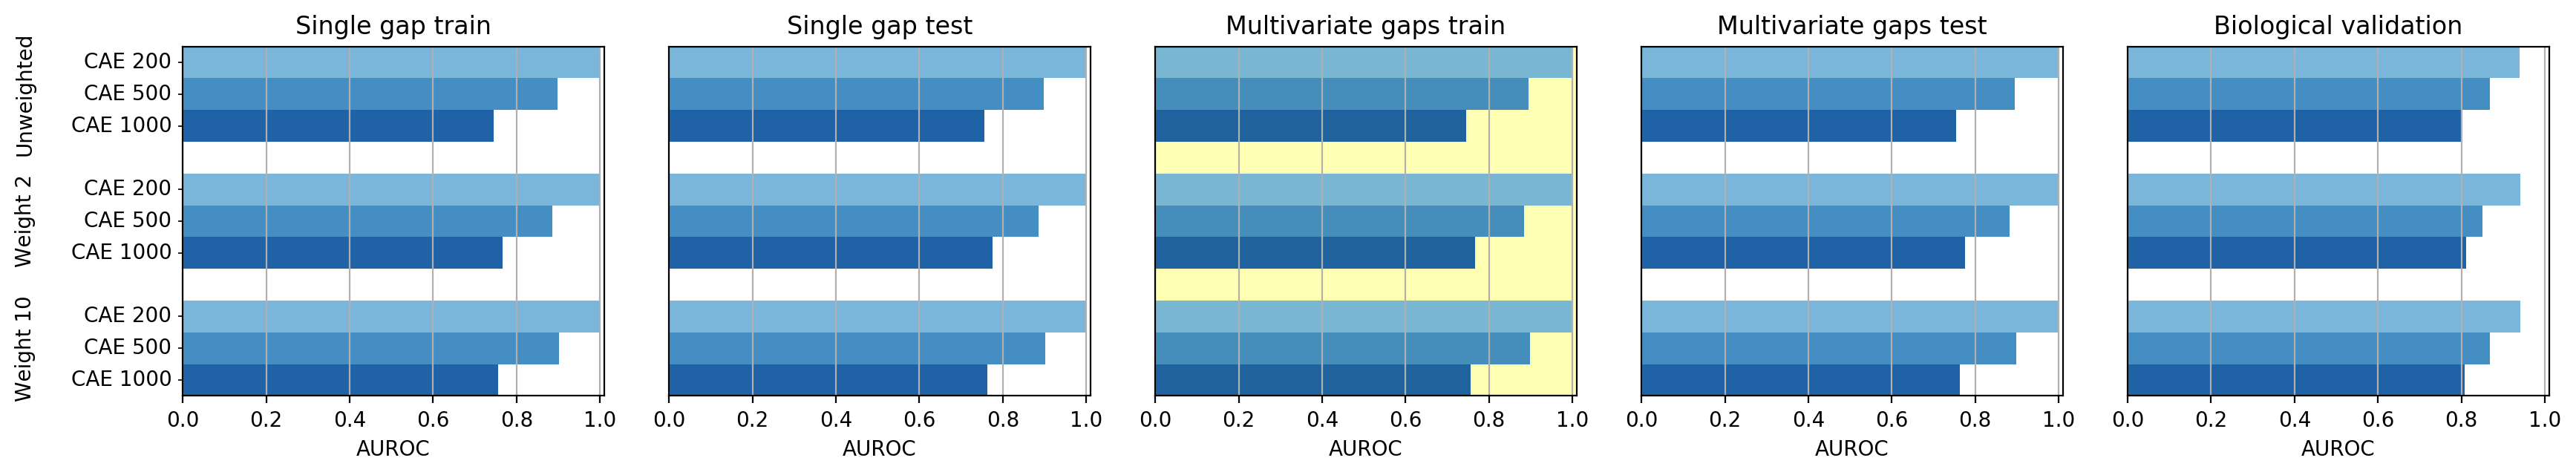

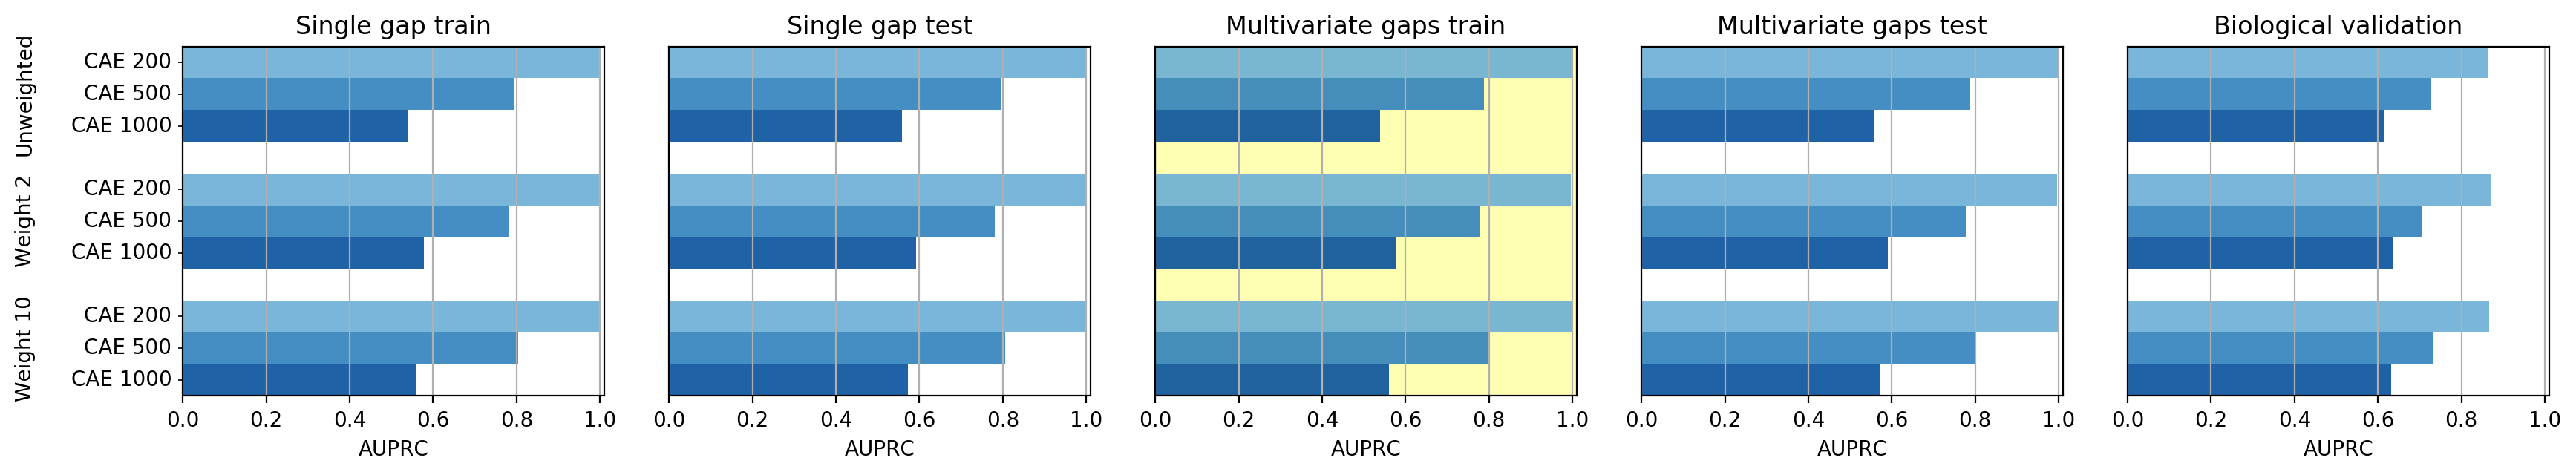

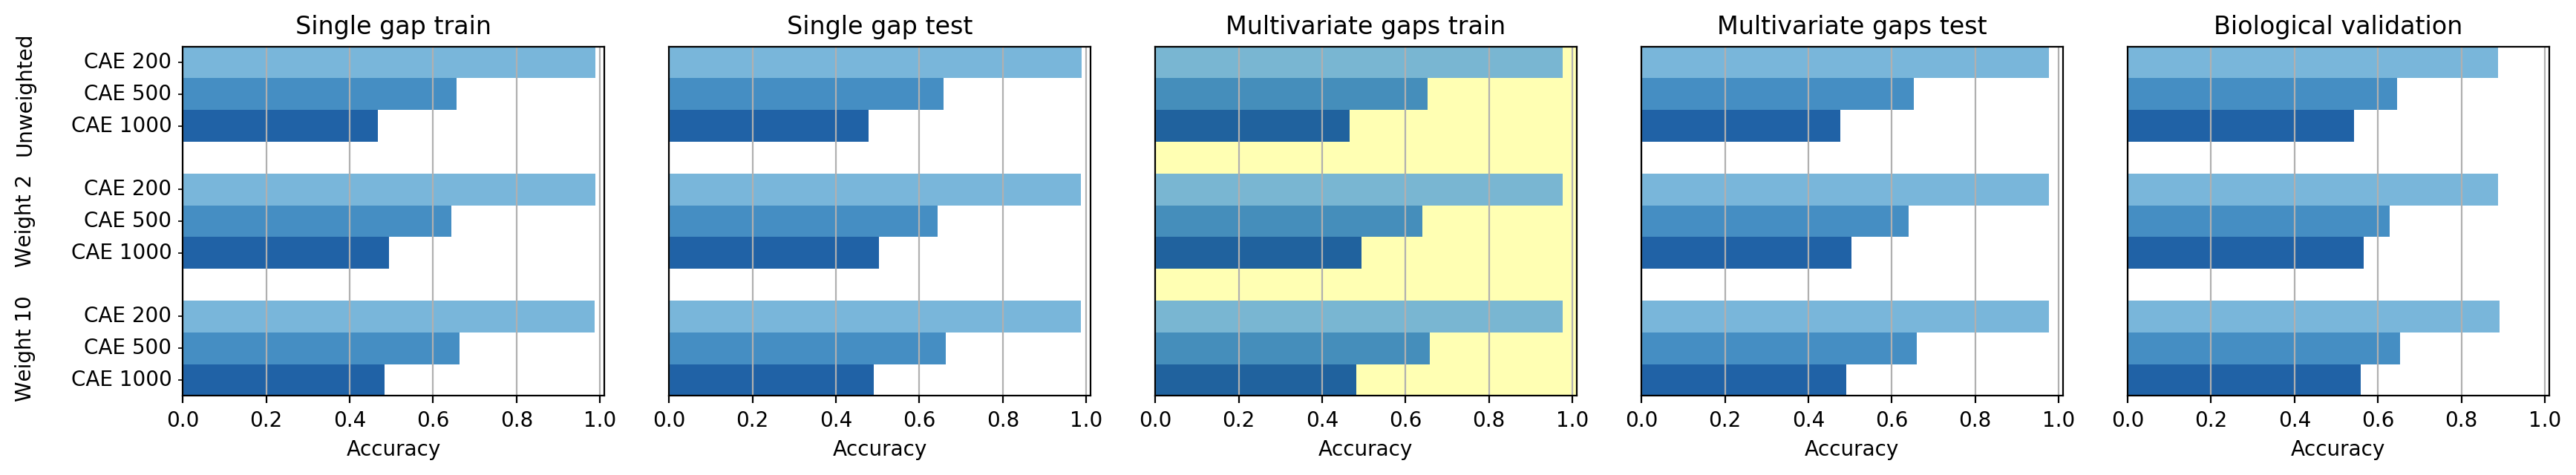

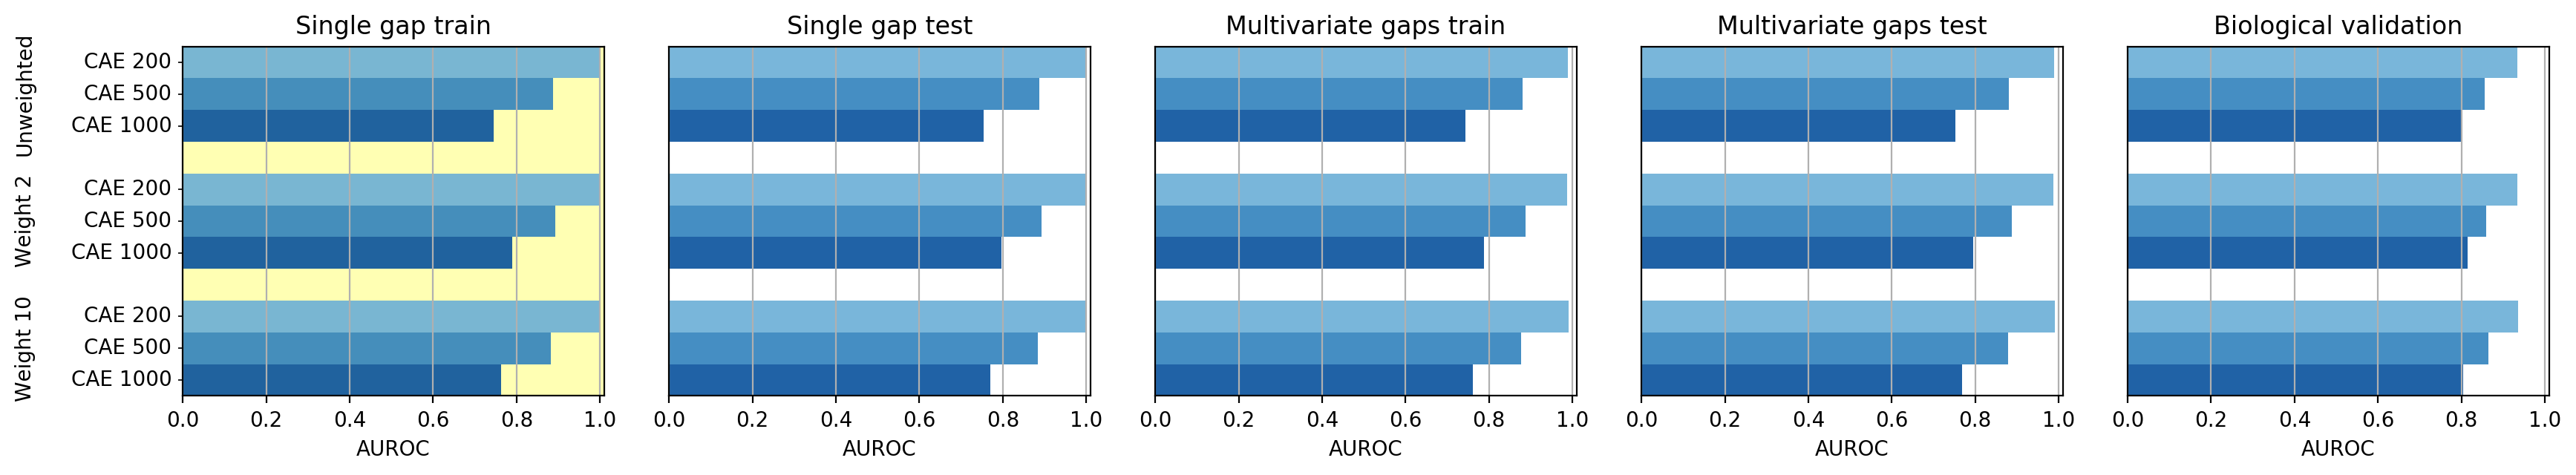

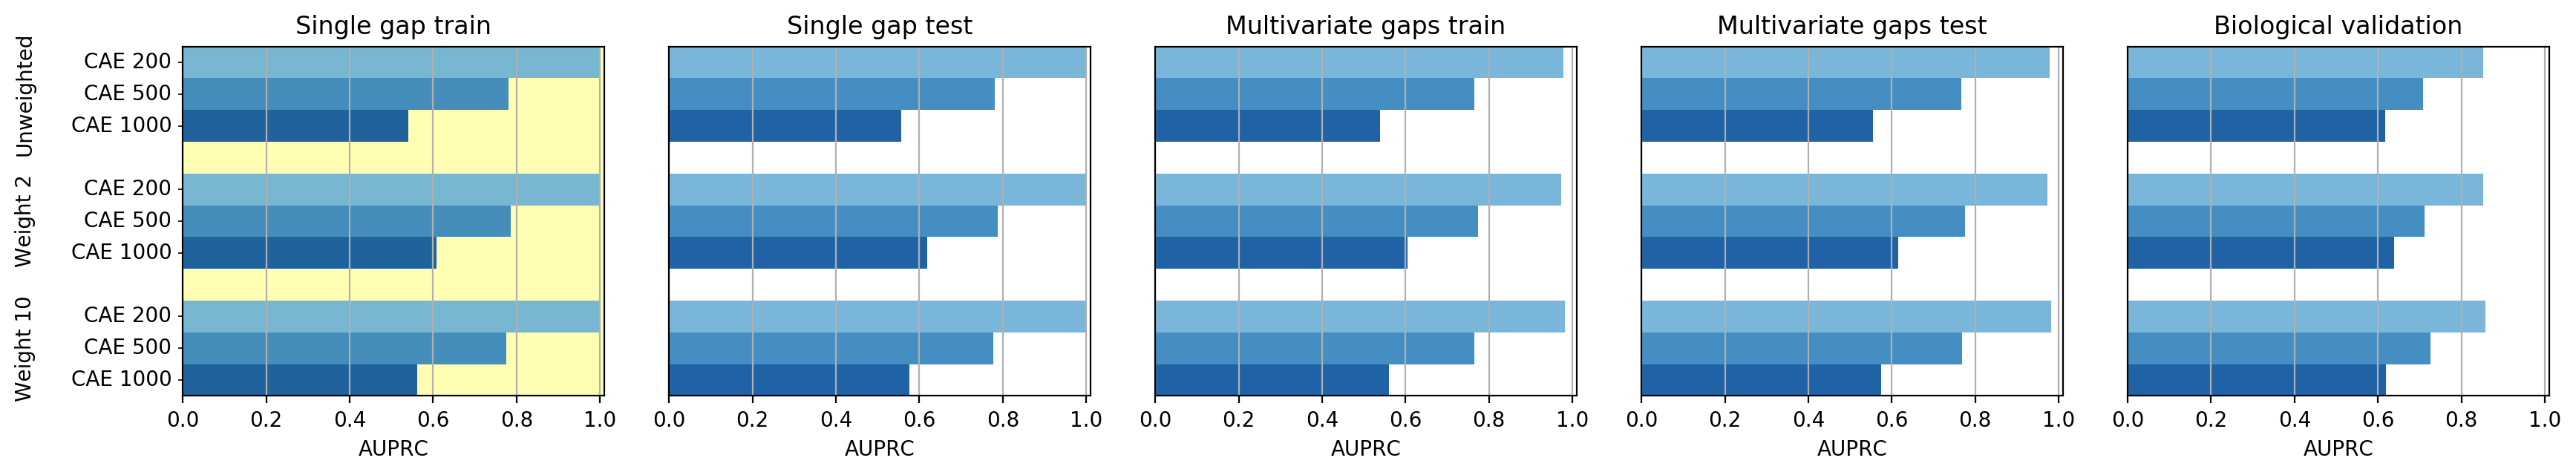

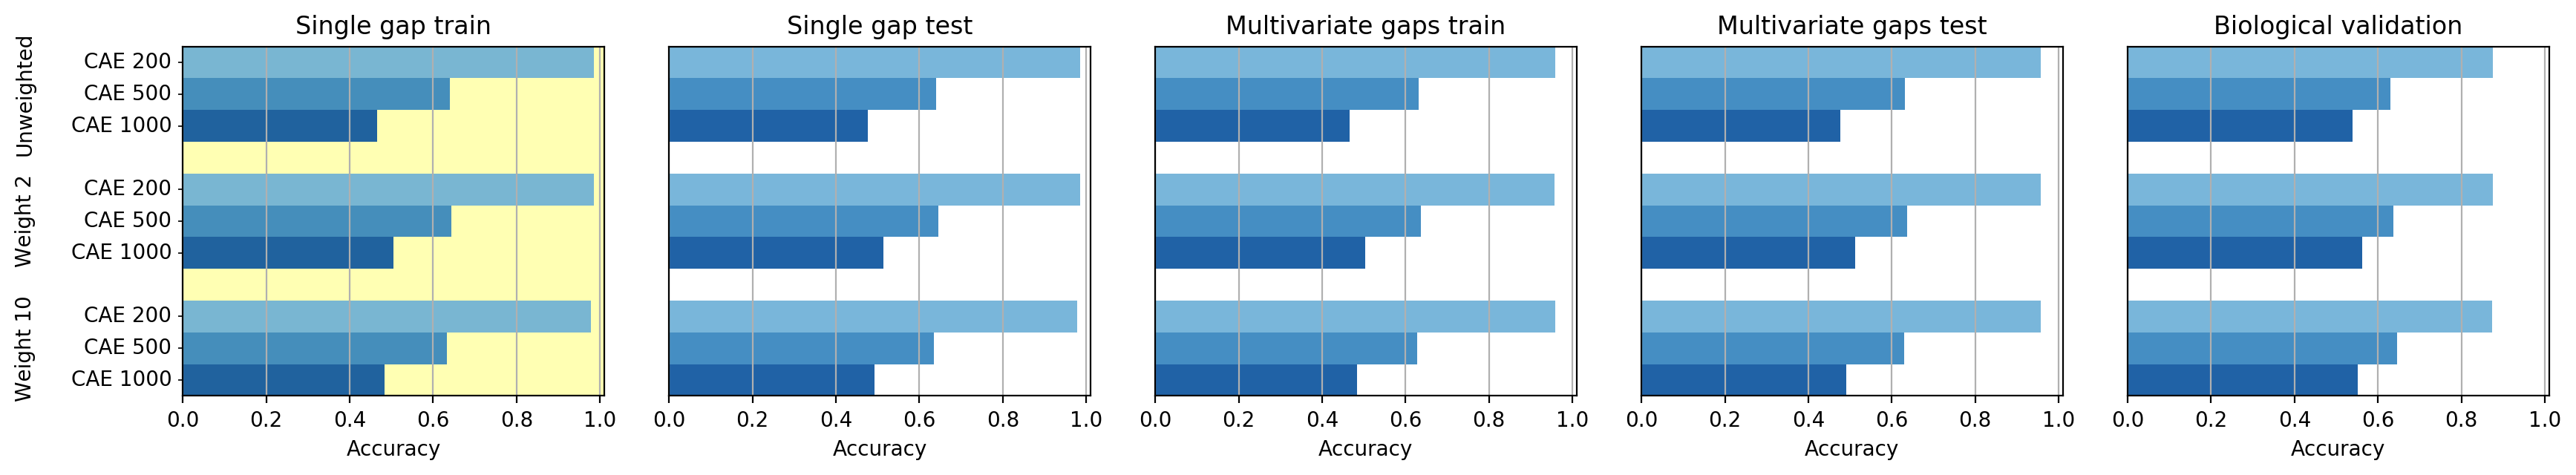

In [7]:
for task in results.task.unique():
    results1 = results[results.task==task]
    #results1 = results1[results1.run_type!="biological validation"]
    results1 = results1[results1.target=="all_nucleotides"]
    results1 = results1[results1.model.str.contains("cae")]
    results1["window"] = [
        "cae {}".format(window)
        for window in results1.window
    ]
    results1 = results1.drop(columns=["task", "dataset", "model", "target"])

    for trained_on in tqdm(results1.trained_on.unique()):
        tmp = results1[results1.trained_on==trained_on].drop(
            columns=["trained_on"]
        )

        facecolors = {
            key:"white"
            for key in tmp.run_type.unique()
        }

        if "multivariate" in trained_on:
            facecolors["multivariate gaps train"] = facecolor

        if "single" in trained_on:
            facecolors["single gap train"] = facecolor

        barplots(
            tmp,
            groupby=["run_type", "weight", "window"],
            path=f"barplots/cae_weighted_{task}_{trained_on}_{{feature}}",
            height=3.5,
            colors=cae_colors,
            facecolors=facecolors,
            sort_bars=sort_dataframe2,
            **kwargs
        )

# Visualization of gap filling task (CNN models)

In [8]:
def sort_dataframe3(df:pd.DataFrame):
    target = {
        'all_nucleotides':4,
        'adenine':3,
        'cytosine':2,
        'thymine':1,
        'guanine':0
    }
    
    model = {
        key:i
        for i, key in enumerate([
            'cnn_1000',
            'cnn_500',
            'cnn_200'
        ])
    }
    
    df['sort_val'] = [
        model[row.model]
        for (_, row) in df.reset_index().iterrows()
    ]
    return df.sort_values('sort_val').drop(columns='sort_val')

/Users/lucacappelletti/opt/anaconda3/lib/python3.7/site-packages/barplots/barplot.py:240: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  figure.tight_layout()


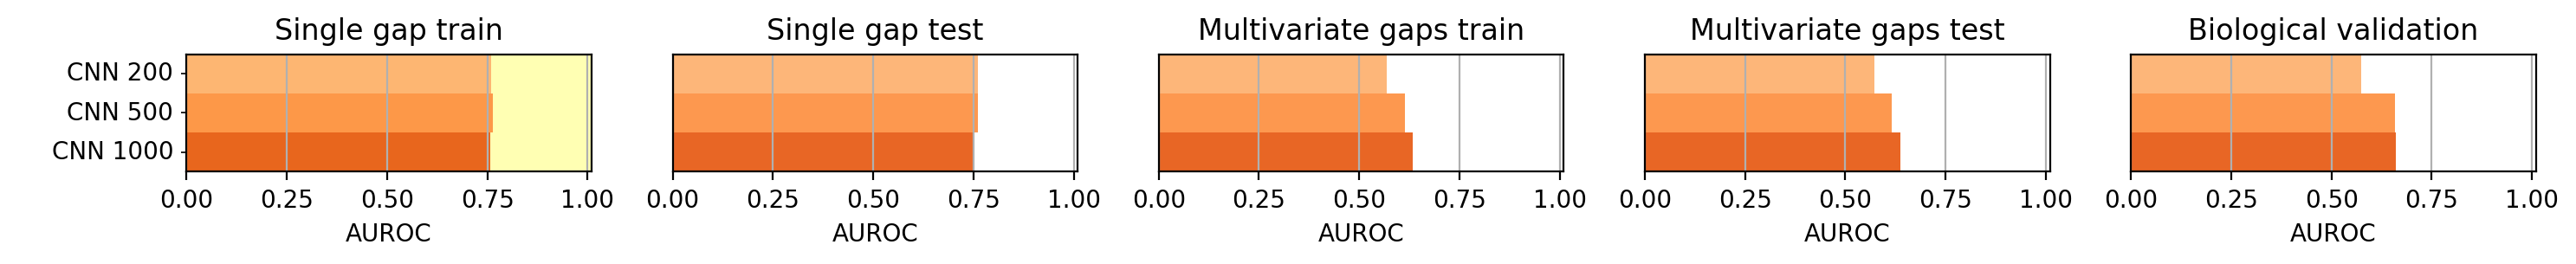

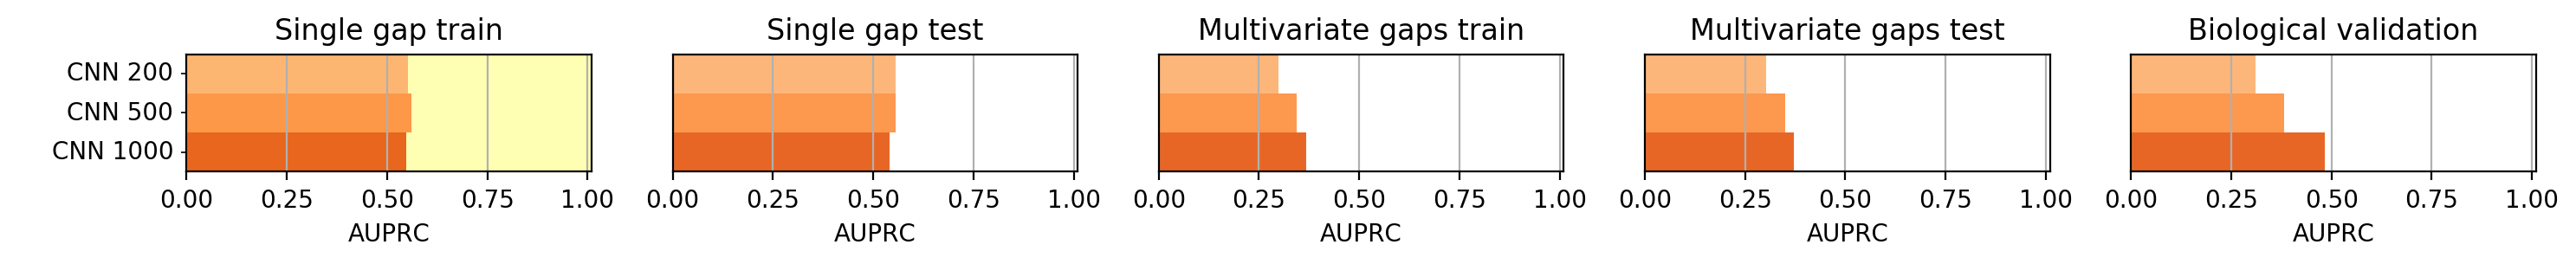

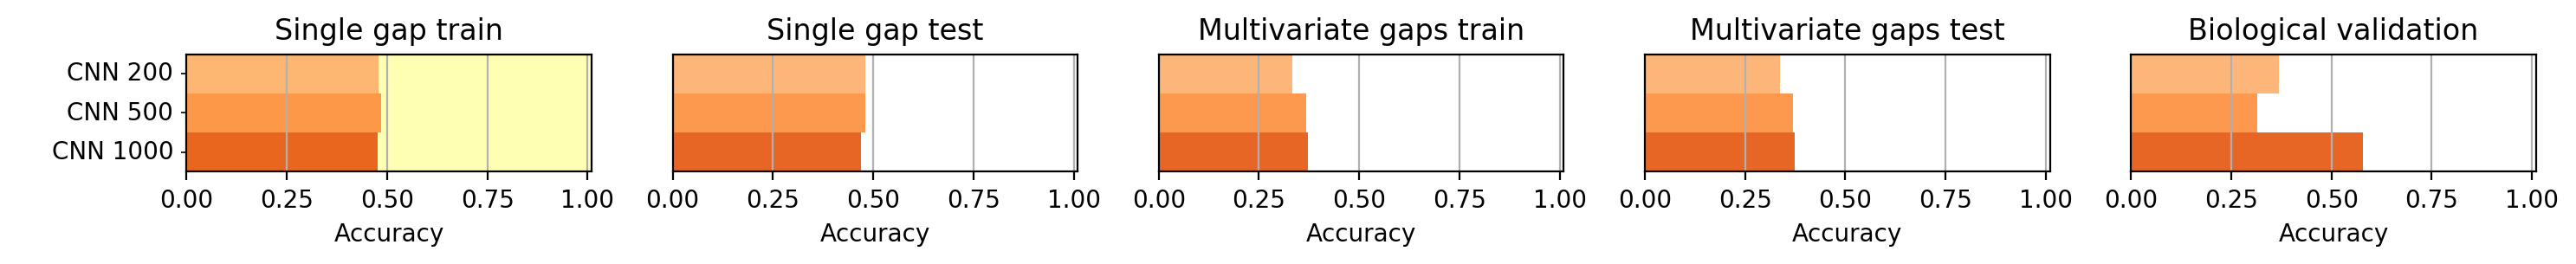

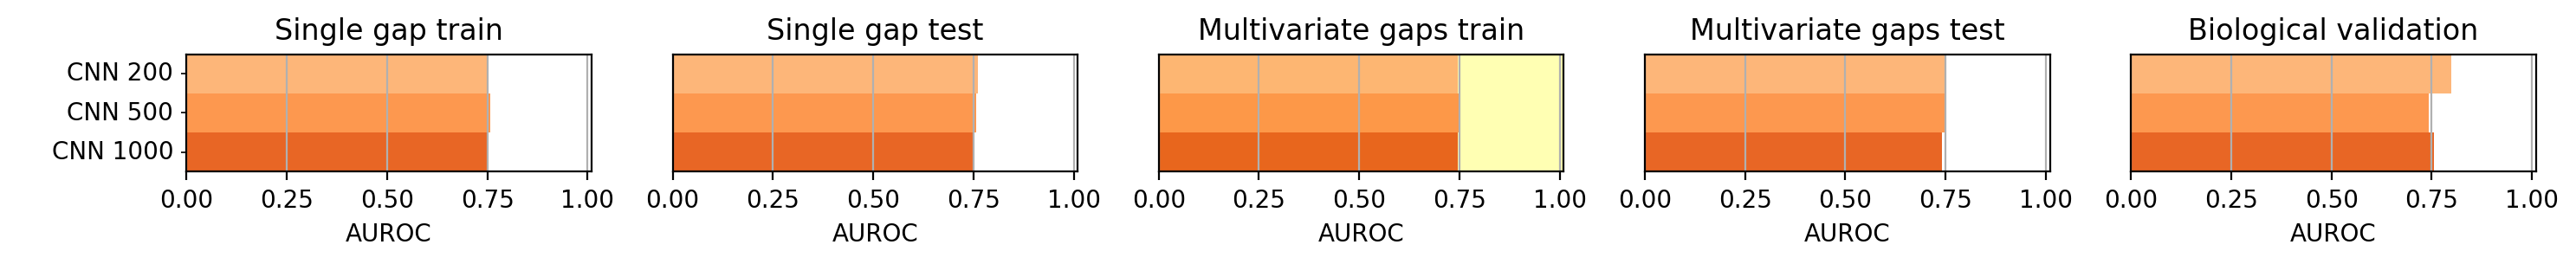

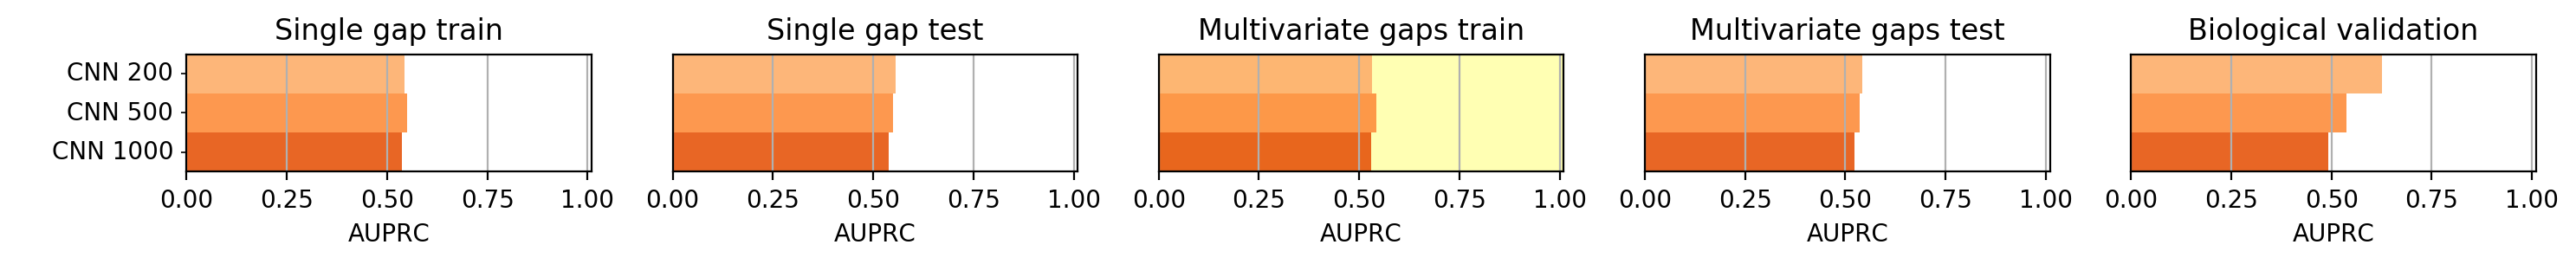

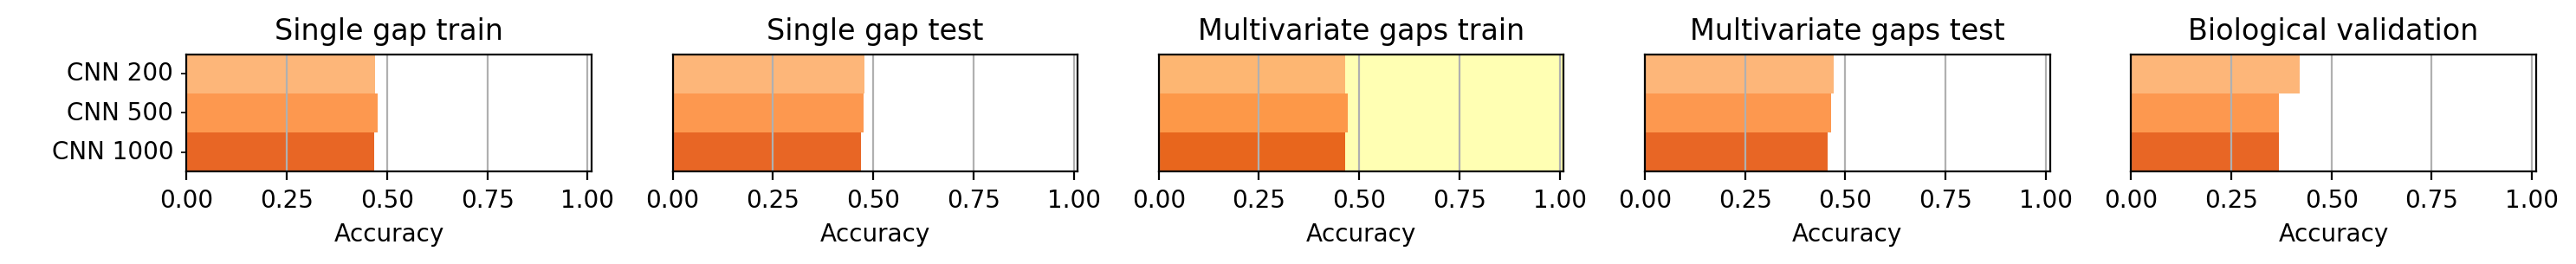

In [9]:
task = "gap_filling"
results1 = results[results.task==task]
#results1 = results1[results1.run_type!="biological validation"]
results1 = results1[results1.target=="all_nucleotides"]
results1 = results1[results1.model.str.contains("cnn")]
results1 = results1.drop(columns=["task", "dataset", "weight", "window"])

for trained_on in tqdm(results1.trained_on.unique()):
    tmp = results1[results1.trained_on==trained_on].drop(
        columns=["trained_on"]
    )

    facecolors = {
        key:"white"
        for key in tmp.run_type.unique()
    }

    if "multivariate" in trained_on:
        facecolors["multivariate gaps train"] = facecolor

    if "single" in trained_on:
        facecolors["single gap train"] = facecolor

    barplots(
        tmp,
        groupby=["run_type", "model"],
        path=f"barplots/cnn_{task}_{trained_on}_{{feature}}",
        height=3.5,
        colors=cnn_colors,
        facecolors=facecolors,
        sort_bars=sort_dataframe3,
        **kwargs
    )

# Visualization of best models

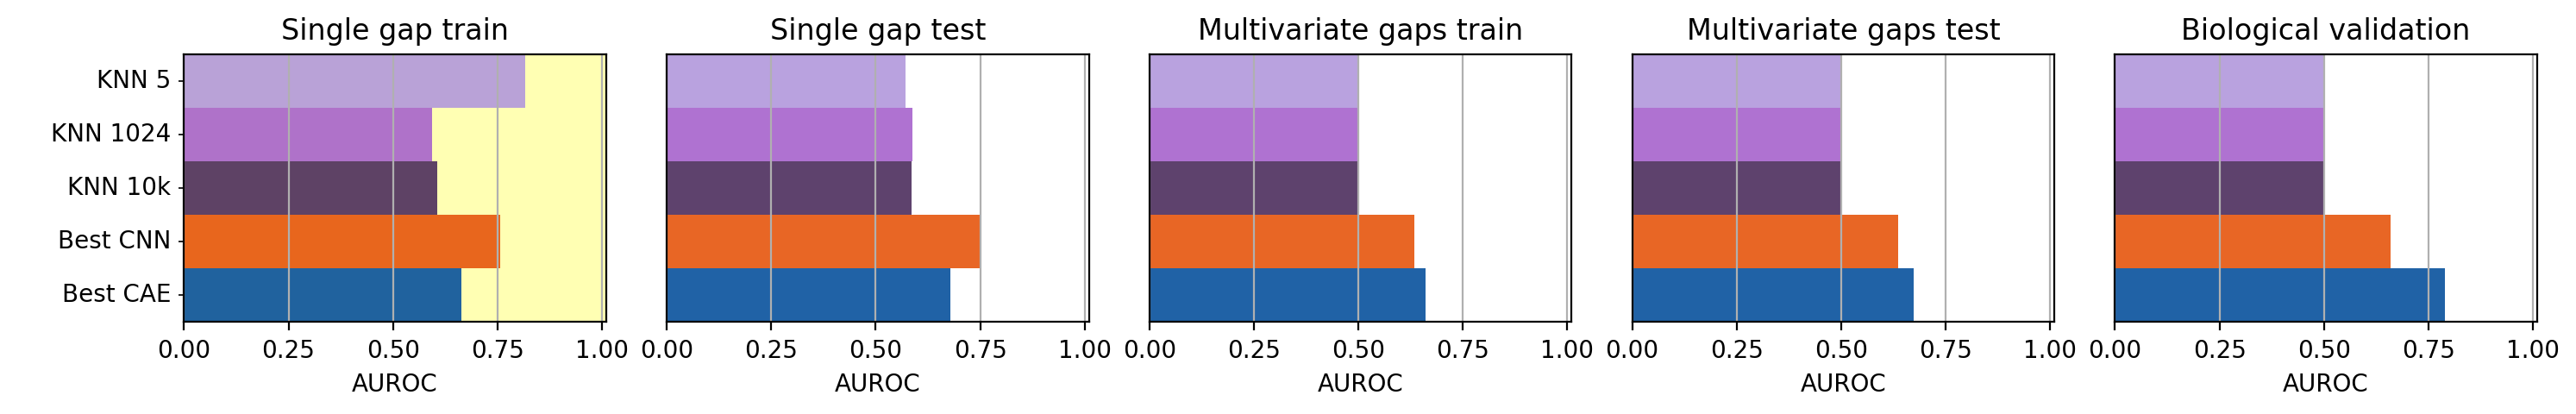

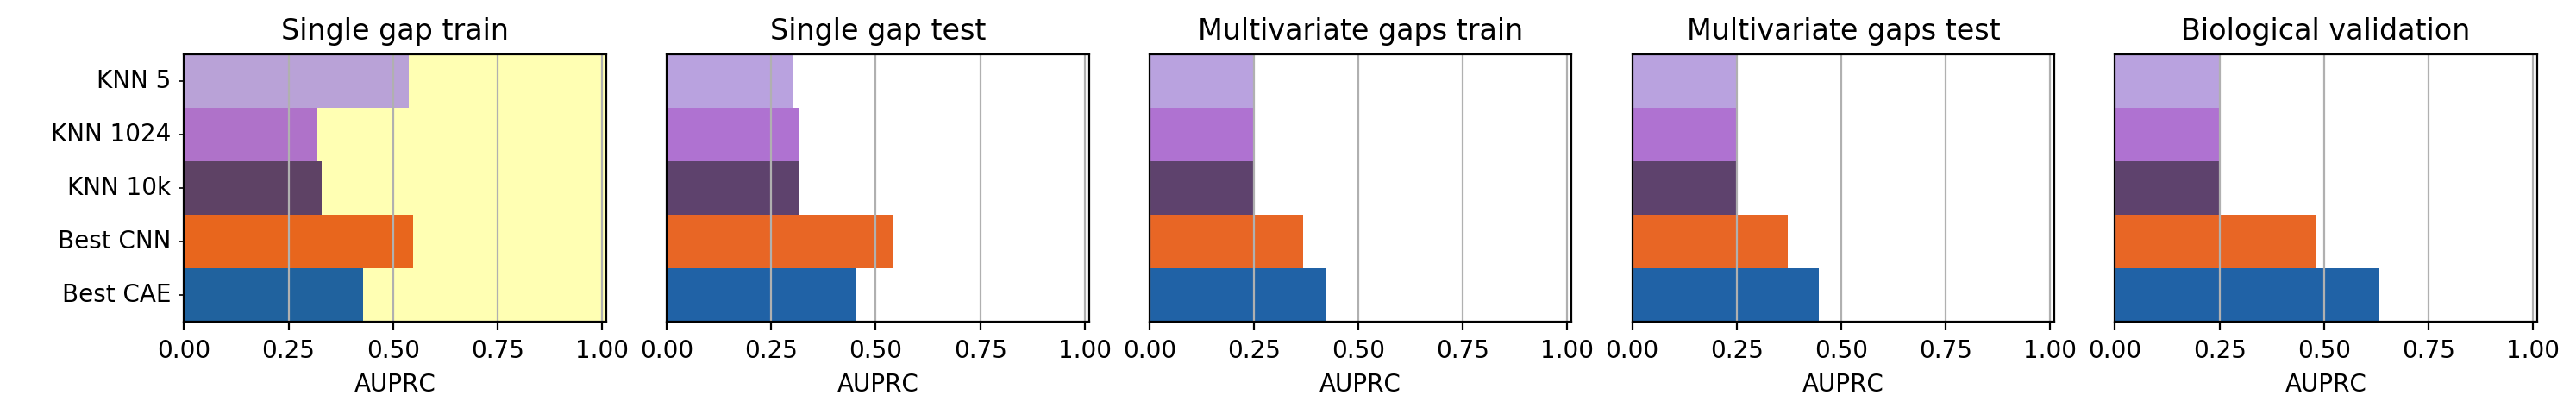

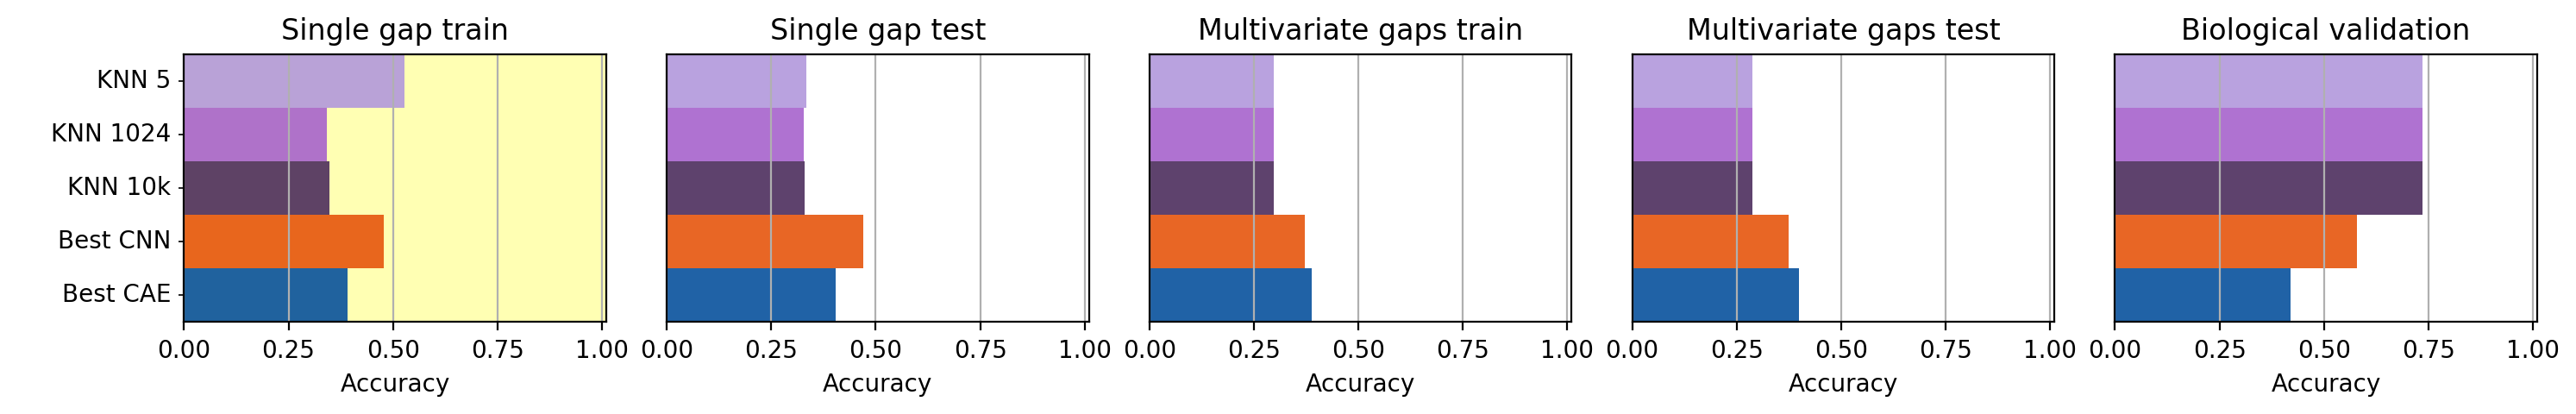

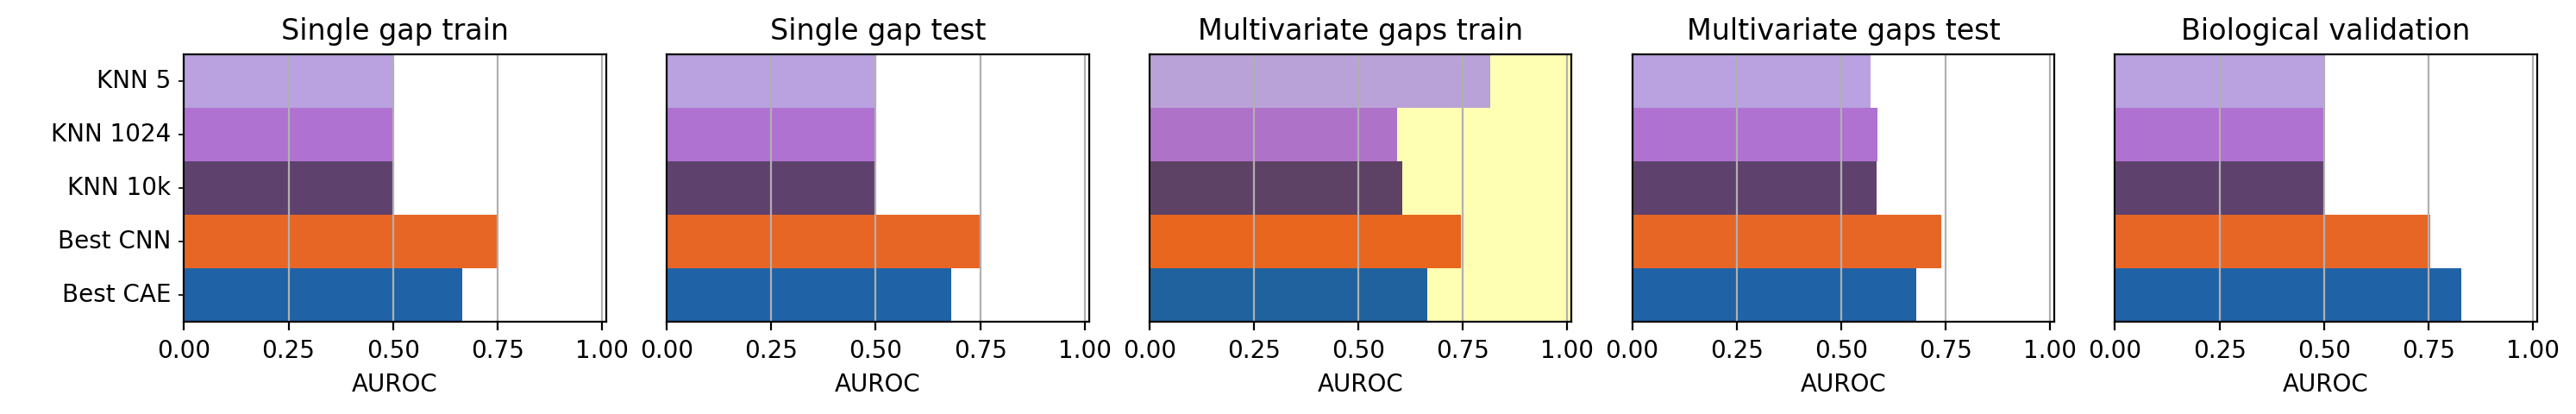

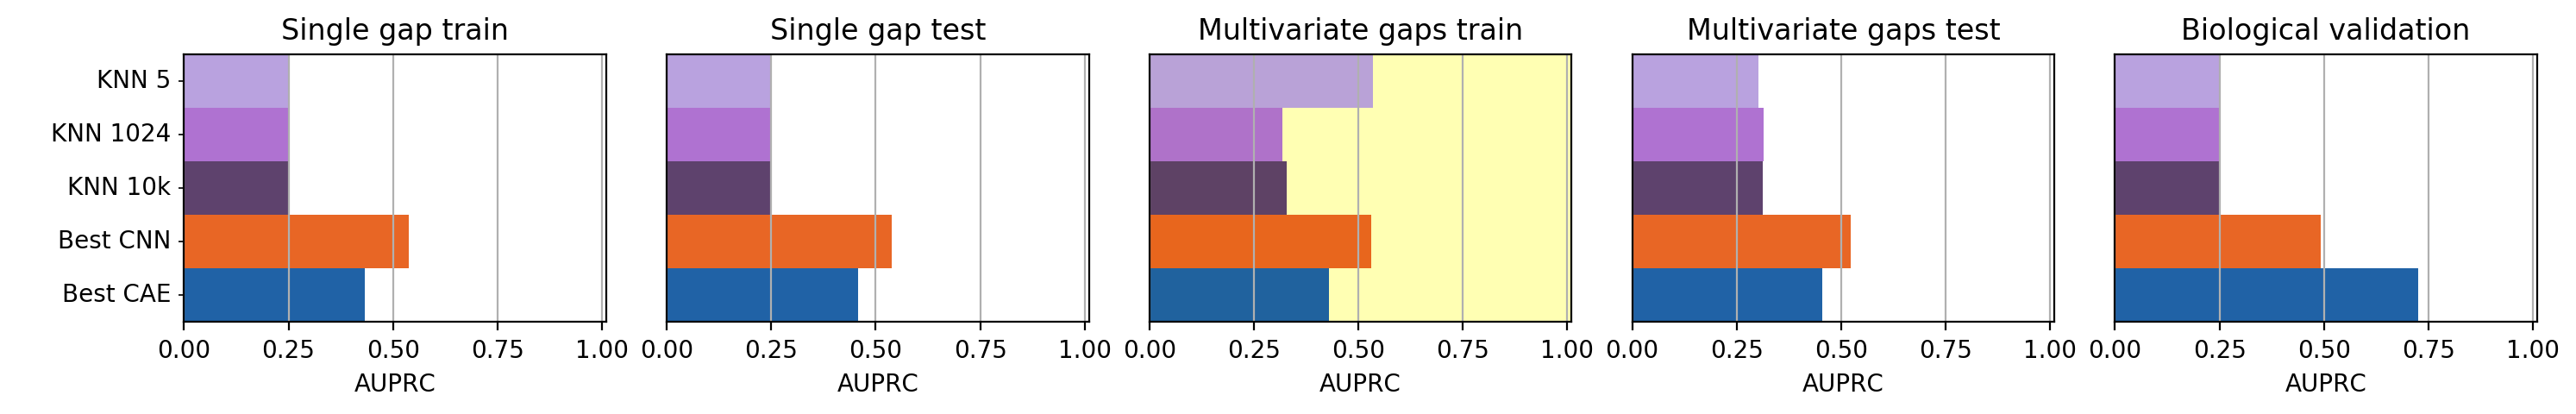

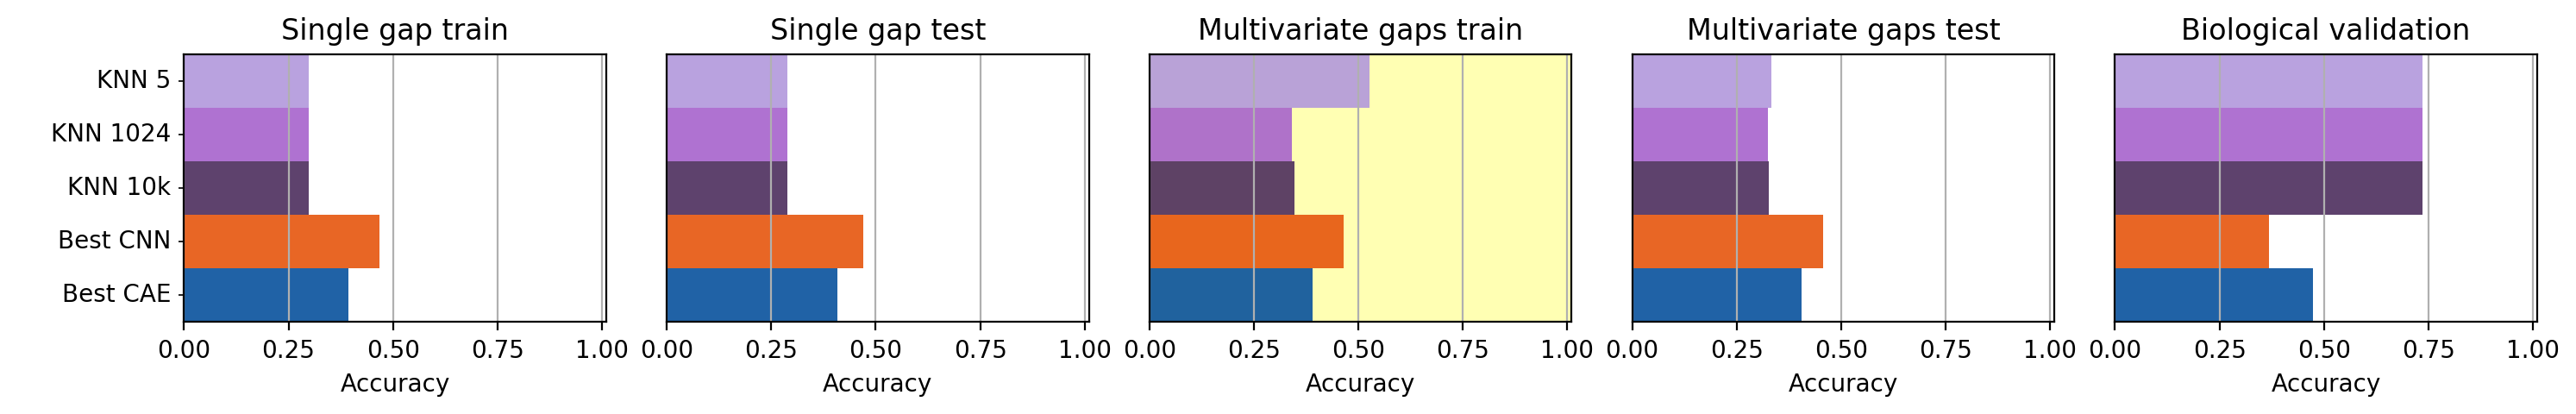

In [10]:
results2 = results.copy()
results2.fillna("", inplace=True)
results2["model"] = results2.model + results2.neighbours
results2 = results2[results2.task=="gap_filling"]
results2 = results2[results2.target=="all_nucleotides"]
results2 = results2[~results2.trained_on.str.contains("weight")]
results2["model"] = results2.model.str.replace("imputer", "")
results2 = results2[results2.model.isin(["cnn_1000", "cae_1000_weight_10", "KNN 10k", "KNN 5", "KNN 1024"])]
results2["model"] = [
    "Best {}".format(m.split("_")[0]) if "1000" in m else m
    for m in results2.model
]

for trained_on in results2.trained_on.unique():
    tmp = results2[results2.trained_on==trained_on].drop(
        columns=["trained_on"]
    )
    
    facecolors = {
        key:"white"
        for key in tmp.run_type.unique()
    }

    if "multivariate" in trained_on:
        facecolors["multivariate gaps train"] = facecolor

    if "single" in trained_on:
        facecolors["single gap train"] = facecolor
        
    #kwargs["orientation"] = "vertical"
    #kwargs["plots_per_row"] = 5
    #kwargs["major_rotation"] = 0
    #kwargs["minor_rotation"] = 90

    barplots(
        tmp,
        ["run_type", "model"],
        path=f"barplots/knn_{trained_on}_{{feature}}",
        facecolors=facecolors,
        height=3,
        bar_width=0.5,
        sort_bars=sort_dataframe1,
        colors=best_models_colors,
        **kwargs
    )